In [2]:
# Install necessary libraries

!pip3 install torch
!pip3 install transformers
!pip3 install datasets
!pip3 install sentencepiece
!pip3 install sacrebleu

In [3]:
import json
import os
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load your generated dataset
# Replace 'your_dataset_path' with the actual path to your dataset
dataset_path = os.path.join("data", "output", "analyzed_dataset.jsonl")

# Load data from the JSONL file
with open(dataset_path, 'r') as file:
    data = [json.loads(line) for line in file]

# Extract input and target values
magic_number_smells = [item['smelly_method'] for item in data]
refactored_codes = [item['refactored_method'] for item in data]

# Split the dataset into training and testing sets
train_magic_number_smells, test_magic_number_smells, train_refactored_codes, test_refactored_codes = train_test_split(
    magic_number_smells, refactored_codes, test_size=0.2, random_state=42
)

# Create dictionaries for training and testing datasets
train_dataset = [{'smelly_method': magic_number_smell, 'refactored_method': refactored_code} for magic_number_smell, refactored_code in zip(train_magic_number_smells, train_refactored_codes)]
test_dataset = [{'smelly_method': magic_number_smell, 'refactored_method': refactored_code} for magic_number_smell, refactored_code in zip(test_magic_number_smells, test_refactored_codes)]

# Save the datasets to JSONL files
train_file_path = os.path.join("data", "output", "train_dataset.jsonl")
test_file_path = os.path.join("data", "output", "test_dataset.jsonl")

In [3]:

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW

with open(train_file_path, 'w') as f:
    for item in train_dataset:
        f.write(json.dumps(item) + '\n')

with open(test_file_path, 'w') as f:
    for item in test_dataset:
        f.write(json.dumps(item) + '\n')

# Define a custom dataset class
class CodeDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        magic_number_smell = item['smelly_method']
        refactored_code = item['refactored_method']

        # Tokenize and convert to PyTorch tensors
        inputs = self.tokenizer.encode_plus(magic_number_smell, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
        targets = self.tokenizer.encode_plus(refactored_code, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze(),
        }

# Initialize the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Create datasets and dataloaders
train_dataset = CodeDataset(train_dataset, tokenizer)
test_dataset = CodeDataset(test_dataset, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define training parameters
optimizer = AdamW(model.parameters(), lr=1e-4)

# Loading onto processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/users/grad/dkapoor/.local/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [4]:
print(refactored_codes)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
train_losses = []
test_losses = []
last_3_test_losses = []  # Track last 5 test losses for early stopping
max_overfit_epochs = 3  # Maximum consecutive epochs for which test loss can increase before stopping

# Training loop
num_epochs = 40
stop_training = False  # Flag to indicate if training should stop

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs} (Training)'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    # Calculate average training loss for the epoch
    train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(train_loss)

    # Evaluate the model on the test dataset
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs} (Testing)'):
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            epoch_test_losses.append(loss.item())

    # Calculate average testing loss for the epoch
    test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(test_loss)

    # Print and/or log the training and testing losses for monitoring
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}")

    # Save checkpoint after each epoch
    checkpoint_path = f'long_statement_s_3200_e40_b4_epoch_{epoch + 1}.pth'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_loss': test_loss
    }, checkpoint_path)
    
    # Early stopping condition for same test losses
    if len(last_3_test_losses) == 3:
        if all(loss == last_3_test_losses[0] for loss in last_3_test_losses):
            print("Early stopping: Test losses remained the same for 3 epochs.")
            stop_training = True
            break
        else:
            last_3_test_losses.pop(0)
    last_3_test_losses.append(test_loss)
    
    # Early stopping condition for overfitting
    if epoch > 0 and test_loss > test_losses[-2]:
        overfit_epochs += 1
        if overfit_epochs >= max_overfit_epochs:
            print(f"Early stopping: Test loss increased continuously for {max_overfit_epochs} epochs.")
            stop_training = True
            break
    else:
        overfit_epochs = 0


    if stop_training:
        break

# Save the trained model
model.save_pretrained('long_statement_model_s_3200_e40_b4')

Epoch 1/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.79it/s]


Epoch 1/40 - Train Loss: 1.4595735932718992, Test Loss: 0.8783085604021155


Epoch 2/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.77it/s]


Epoch 2/40 - Train Loss: 1.0019823566699064, Test Loss: 0.7731531580075895


Epoch 3/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.70it/s]


Epoch 3/40 - Train Loss: 0.8901902500120995, Test Loss: 0.7168742630379331


Epoch 4/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.69it/s]


Epoch 4/40 - Train Loss: 0.8202776252213171, Test Loss: 0.6807232545745885


Epoch 5/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.65it/s]


Epoch 5/40 - Train Loss: 0.7665143865053018, Test Loss: 0.6453260033408557


Epoch 6/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.63it/s]


Epoch 6/40 - Train Loss: 0.7245313483641952, Test Loss: 0.6240190339554672


Epoch 7/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.66it/s]


Epoch 7/40 - Train Loss: 0.6913239232197014, Test Loss: 0.6077290217112179


Epoch 8/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 8/40 - Train Loss: 0.6613421696130594, Test Loss: 0.5883626748173515


Epoch 9/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.63it/s]


Epoch 9/40 - Train Loss: 0.6371311685084745, Test Loss: 0.5726723449270418


Epoch 10/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.65it/s]


Epoch 10/40 - Train Loss: 0.614061665025257, Test Loss: 0.5616125093281634


Epoch 11/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.47it/s]


Epoch 11/40 - Train Loss: 0.5946795224385747, Test Loss: 0.5541911509139407


Epoch 12/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.65it/s]


Epoch 12/40 - Train Loss: 0.5755154660376268, Test Loss: 0.5347572393898218


Epoch 13/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.63it/s]


Epoch 13/40 - Train Loss: 0.5583253837720088, Test Loss: 0.5296598914439327


Epoch 14/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.65it/s]


Epoch 14/40 - Train Loss: 0.5425424735723364, Test Loss: 0.5246012625655879


Epoch 15/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.40it/s]


Epoch 15/40 - Train Loss: 0.5287774277647214, Test Loss: 0.5140836462378502


Epoch 16/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.56it/s]


Epoch 16/40 - Train Loss: 0.5155478282752683, Test Loss: 0.5144376163056658


Epoch 17/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.56it/s]


Epoch 17/40 - Train Loss: 0.5031121121647729, Test Loss: 0.5088249797150035


Epoch 18/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 18/40 - Train Loss: 0.49048111129707106, Test Loss: 0.5030873849119512


Epoch 19/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 19/40 - Train Loss: 0.47913846668596444, Test Loss: 0.49219620694046373


Epoch 20/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.67it/s]


Epoch 20/40 - Train Loss: 0.46844678226347514, Test Loss: 0.4898755350178736


Epoch 21/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 21/40 - Train Loss: 0.4582563032767806, Test Loss: 0.4851780142292289


Epoch 22/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.56it/s]


Epoch 22/40 - Train Loss: 0.4490939634629684, Test Loss: 0.48190328983898545


Epoch 23/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.65it/s]


Epoch 23/40 - Train Loss: 0.43979258175210334, Test Loss: 0.4779836310565106


Epoch 24/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 24/40 - Train Loss: 0.4324033545970182, Test Loss: 0.47714214470306054


Epoch 25/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.57it/s]


Epoch 25/40 - Train Loss: 0.4235659474377823, Test Loss: 0.47633261011879136


Epoch 26/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.66it/s]


Epoch 26/40 - Train Loss: 0.4151802334951693, Test Loss: 0.46381468079024296


Epoch 27/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 27/40 - Train Loss: 0.40674388674138046, Test Loss: 0.46125941447045177


Epoch 28/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 28/40 - Train Loss: 0.399975780323033, Test Loss: 0.4679074831809734


Epoch 29/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 29/40 - Train Loss: 0.3918633484360525, Test Loss: 0.4601232093398922


Epoch 30/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.57it/s]


Epoch 30/40 - Train Loss: 0.38589595140564975, Test Loss: 0.45669318097957806


Epoch 31/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.65it/s]


Epoch 31/40 - Train Loss: 0.3793672076003118, Test Loss: 0.4554047671609495


Epoch 32/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 32/40 - Train Loss: 0.37279577085458443, Test Loss: 0.4530424312945524


Epoch 33/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 33/40 - Train Loss: 0.3657950102846685, Test Loss: 0.44660019956849106


Epoch 34/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 34/40 - Train Loss: 0.3595310024750664, Test Loss: 0.4528623762671933


Epoch 35/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.68it/s]


Epoch 35/40 - Train Loss: 0.3541719647316701, Test Loss: 0.4464447839311296


Epoch 36/40 (Testing): 100%|██████████| 163/163 [00:12<00:00, 13.51it/s]


Epoch 36/40 - Train Loss: 0.3475037336820171, Test Loss: 0.4514129817302973


Epoch 37/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.66it/s]


Epoch 37/40 - Train Loss: 0.34259276743547756, Test Loss: 0.4492680840308498


Epoch 38/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.66it/s]


Epoch 38/40 - Train Loss: 0.33700517755007525, Test Loss: 0.44107511380195985


Epoch 39/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.66it/s]


Epoch 39/40 - Train Loss: 0.33143303630577947, Test Loss: 0.4439556756816759


Epoch 40/40 (Testing): 100%|██████████| 163/163 [00:11<00:00, 13.64it/s]


Epoch 40/40 - Train Loss: 0.32725741465121094, Test Loss: 0.44676733125526846


In [6]:
# Testing the model

model.eval()
all_references = []  # List to store reference sequences
all_predictions = []  # List to store predicted sequences
all_prediction_ids = []
all_prediction_ids_labelled = []
all_predictions_decoded = []
all_predictions_decoded_labelled = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Evaluating on Test Dataset'):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # Generate predictions
        predicted_ids = model.generate(**inputs, max_length=512)
        predicted_code = [tokenizer.decode(ids, skip_special_tokens=True) for ids in predicted_ids]

        # Append to reference and prediction lists
        all_references.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_code)

        all_prediction_ids.extend(predicted_ids)
        all_prediction_ids_labelled.extend(predicted_ids.cpu().numpy())

        tokenized_predicted_code = [tokenizer.encode_plus(code, return_tensors='pt', padding='max_length', truncation=True, max_length=512) for code in predicted_code]
        all_predictions_decoded.extend(tokenized_predicted_code)
        labels_predicted = torch.stack([item['input_ids'].squeeze() for item in tokenized_predicted_code])
        # all_predictions_decoded_labelled.extend(labels_predicted.cpu.numpy())
        all_predictions_decoded_labelled.extend(labels_predicted.numpy())


# Save the results to a text file
with open('test_results.txt', 'w') as file:
    for reference, prediction in zip(all_references, all_predictions):
        file.write(f"Reference: {reference}\n")
        file.write(f"Prediction: {prediction}\n\n")


Evaluating on Test Dataset: 100%|██████████| 163/163 [08:08<00:00,  3.00s/it]


In [7]:
# # Assuming refactored_codes is a list of strings containing code snippets

# # Remove tabs and newline characters
# refactored_codes_cleaned = [code.replace('  ', '').replace('\n', '') for code in refactored_codes]

# # Print the cleaned refactored codes
# for code in refactored_codes_cleaned:
#     print(code)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# !pip3 install sacrebleu

import sacrebleu

# Check if the lists are not empty
if all_predictions and refactored_codes:
    # Convert NumPy arrays to Python lists of strings
    references = [str(ref) for ref in refactored_codes]
    predictions = [str(pred) for pred in all_predictions]

    # Calculate CodeBLEU
    codebleu = sacrebleu.corpus_bleu(predictions, [references])
    print(f"CodeBLEU: {codebleu.score}")
#     print(refactored_codes)
#     print(all_predictions)
else:
    print("Error: Empty prediction or reference list.")


In [10]:
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize lists to store individual ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Iterate over refactored_codes and all_predictions
for ref_code, pred_code in zip(refactored_codes, all_predictions):
    # Calculate ROUGE scores
    scores = scorer.score(ref_code, pred_code)
    
    # Append individual ROUGE scores
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate mean ROUGE scores
mean_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
mean_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
mean_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# Print mean ROUGE scores
print("Mean ROUGE-1:", mean_rouge1)
print("Mean ROUGE-2:", mean_rouge2)
print("Mean ROUGE-L:", mean_rougeL)


Mean ROUGE-1: 0.07171566405311433
Mean ROUGE-2: 0.0043182830912395056
Mean ROUGE-L: 0.057856933812938084


In [ ]:
import nltk
from nltk.translate import meteor_score

# Download WordNet data
nltk.download('wordnet')

# Check if the lists are not empty
if all_predictions and refactored_codes:
    # Convert NumPy arrays to strings
    hypothesis_strings = [str(pred) for pred in all_predictions]

    # Preprocess references by converting to strings
    references_strings = []
    for ref in refactored_codes:
        # Convert each tokenized reference to a single string
        ref_string = ' '.join([str(token) for token in ref])
        references_strings.append(ref_string)

    # Calculate METEOR score
    meteor_avg_score = meteor_score.meteor_score(references_strings, hypothesis_strings)
    print(f"METEOR: {meteor_avg_score}")
else:
    print("Error: Empty prediction or reference list.")


In [11]:
import nltk
from nltk.translate import meteor_score

# Download WordNet data
nltk.download('wordnet')

# Check if the lists are not empty
if all_predictions and refactored_codes:
    # Convert NumPy arrays to strings
    hypothesis_strings = [str(pred) for pred in all_predictions]

    # Preprocess references by converting to strings
    references_strings = []
    for ref in refactored_codes:
        # Convert each tokenized reference to a single string
        ref_string = ' '.join([str(token) for token in ref])
        references_strings.append(ref_string)

    # Calculate METEOR score
    meteor_avg_score = meteor_score.meteor_score(references_strings, hypothesis_strings)
    print(f"METEOR: {meteor_avg_score}")
else:
    print("Error: Empty prediction or reference list.")


[nltk_data] Downloading package wordnet to
[nltk_data]     /users/grad/dkapoor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


METEOR: 0.0


In [12]:
print(all_predictions)

['protected void assertSelection(Uri uri, ContentValues values, String idColumn, long id)  if (USE_LEGACY_PROVIDER)  // A bug in the legacy ContactsProvider prevents us from using the // _id column in selection. super.assertSelection(uri, values, null, 0);  else  values.put(idColumn, idColumn, id); super.assertSelection(uri, values, idColumn, id);', 'public void executeAsync(final InternalConnection connection, final SingleResultCallbackBulkWriteResult> callback)  SingleResultCallbackBulkWriteResult> errHandlingCallback = errorHandlingCallback(callback, connection.getDescription()); executeBatchesAsync(connection, createRequestMessage(getMessageSettings(connection.getDescription())), new BulkWriteBatchCombiner(connection.getDescription().getServerAddress(), ordered, writeConcern), 0, 0, callback);', 'public VersionResult resolveVersion( RepositorySystemSession session, VersionRequest request ) throws VersionResolutionException  RequestTrace trace = RequestTrace.newChild( request.getTra

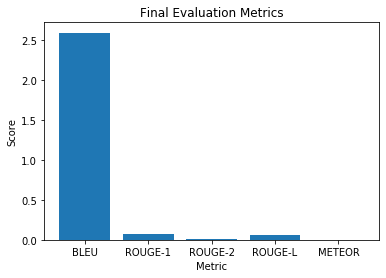

In [24]:
import matplotlib.pyplot as plt

# Define metrics
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR']

final_scores = [codebleu.score,  mean_rouge1,  mean_rouge2, mean_rougeL, meteor_avg_score]

# Plotting final scores
plt.bar(metrics, final_scores)

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Final Evaluation Metrics')

# Show plot
plt.show()


In [ ]:
import sacrebleu

# Calculate BLEU score
bleu_score = sacrebleu.corpus_bleu(all_predictions, [refactored_code])

# Compute CodeBLEU score
code_bleu_score = bleu_score.score

# Print CodeBLEU score
print("CodeBLEU Score:", code_bleu_score)